## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import os
import math
import collections

## Load Data

In [2]:
# class Observation:
#     def __init__(self, mag_field_volt, mag_field_curr, filter, sample, min_trans_eye,
#                 angles, intensities):
#         self.mag_field_volt = mag_field_volt
#         self.mag_field_curr = mag_field_curr
#         self.filter = filter
#         self.sample = sample
#         self.min_trans_eye = min_trans_eye
#         self.angles = angles
#         self.intensities = intensities

from faraday_common import Observation

In [3]:
data_file = 'data/faraday_data.xlsx'

In [4]:
full_df = pd.read_excel(data_file)
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Value 6,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,0.00250,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,0.00275,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,0.00447,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,0.00696,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,0.01620,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,0.00360,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,0.00499,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,0.00615,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,0.00202,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234


In [5]:
observation_arr = []
for i, row in full_df.iterrows():
    mag_field_volt, mag_field_curr, filter, sample, min_trans_eye = row[0:5].values
    angles = [row[f"Angle {j}"] for j in range(1, 10)]
    intensities = [row[f"Value {j}"] for j in range(1, 10)]
    observation = Observation(mag_field_volt, 
                              mag_field_curr, 
                              filter, 
                              sample, 
                              min_trans_eye, 
                              angles, 
                              intensities)
    observation_arr.append(observation)

### Magnetic Field Data

In [6]:
mError = 0.1 #mT
currentError = 0.01 #amps

#Hysterysis equation y = mx+b where y = B field in mT and m = current in amps
m = 190.86
b = -0.0152


## Malus Fit Class

In [7]:
# class MalusFit:
#     def __init__(self, observation):
#         self.observation = observation
#         self.angles = observation.angles
#         self.intensities = observation.intensities
#         self.fit()
        
#     def fit(self):
#         """
#         Fit malus curve to angles and intensities
#         """
#         m1_guess = np.max(intensities)
#         m2_guess = np.max(intensities)
#         m3_guess = angles[np.argmin(intensities)]
#         params, covariance = curve_fit(self.malus_curve, 
#                                            self.angles, 
#                                            self.intensities, 
#                                            p0=[m1_guess, m2_guess, m3_guess])
#         self.m1, self.m2, self.m3 = params
        
#     def malus_curve(self, x, m1, m2, m3):
#         return m1 - m2 * (np.cos(np.deg2rad(x - m3))) ** 2

#     def get_min_angle(self):
#         """
#         Find the minimum transmission angle based on fit parameters
#         """
#         return self.m3

#     def plot_fit(self, ax):
#         """
#         Plot malus fit to intensities, with both data and fitted curve
#         """
#         fit_angles = np.linspace(np.min(self.angles), 
#                                  np.max(self.angles), 
#                                  100)
#         fitted_intensities = self.malus_curve(fit_angles, 
#                                               self.m1, 
#                                               self.m2, 
#                                               self.m3)
#         ax.plot(fit_angles, fitted_intensities, color = "red")
#         ax.scatter(self.angles, self.intensities)
#         ax.set_title(f"{self.observation.mag_field_volt} V," 
#                      f"{self.observation.filter},"
#                      f"{self.observation.sample}")

from faraday_common import MalusFit

## Create 0 magnetic field fits

In [8]:
import collections
zero_field_angles = collections.defaultdict(dict)

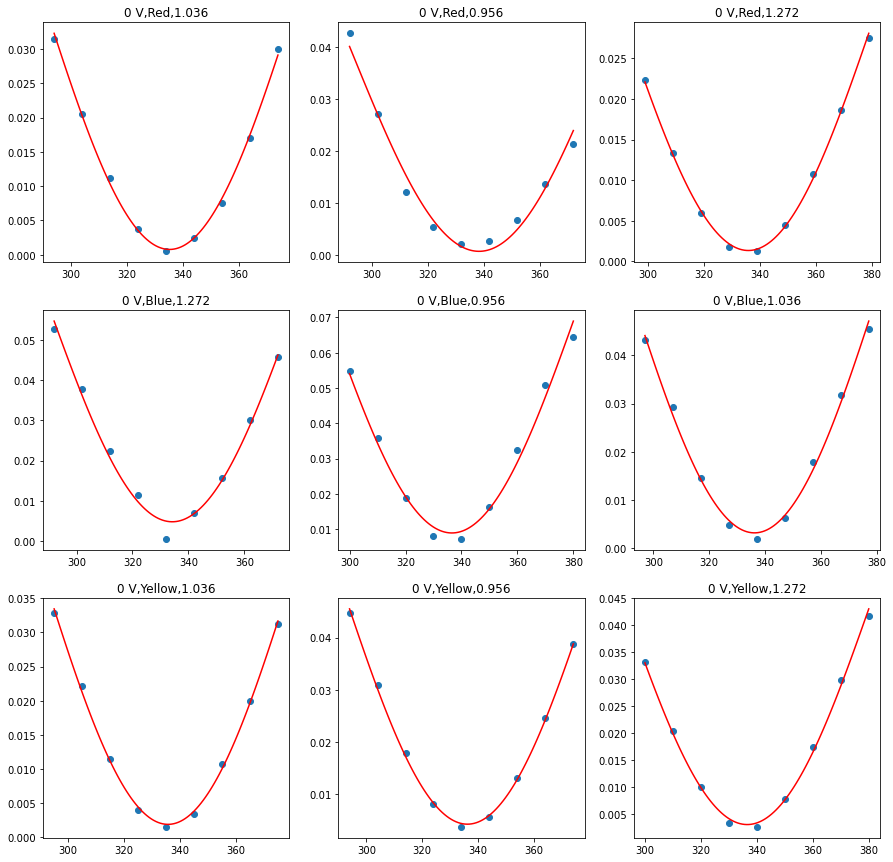

In [9]:
## Fit the 9 0 field datapoints
fig, axes = plt.subplots(3, 3, figsize = (15, 15))

mDict = {} #Stores the parameters of the lines of best fit, structure: {key = {sample}_{filter}, value = {key = "mi", value = mi}}
for i, ax in enumerate(axes.flatten()):
    observation = observation_arr[i]
    mf = MalusFit(observation)
    mDict[f"{mf.observation.sample}_{mf.observation.filter}"] = {"m1": mf.m1, "m2": mf.m2, "m3": mf.m3}
    mf.plot_fit(ax)
    zero_field_angles[observation.filter][observation.sample] = mf.get_min_angle()

In [9]:
zero_field_angles

defaultdict(dict,
            {'Red': {1.036: 335.274925890484,
              0.956: 338.28784039026385,
              1.272: 335.95791532842117},
             'Blue': {1.272: 334.2244603785799,
              0.956: 336.57688964189674,
              1.036: 336.1480069830858},
             'Yellow': {1.036: 335.6961290674026,
              0.956: 336.1317016374635,
              1.272: 336.54722589233563}})

In [10]:
mDict

{'1.036_Red': {'m1': 0.07320082950131986,
  'm2': 0.07242662219366228,
  'm3': 335.274925890484},
 '0.956_Red': {'m1': 0.07600340873265846,
  'm2': 0.07524317421585733,
  'm3': 338.28784039026385},
 '1.272_Red': {'m1': 0.058755378942364996,
  'm2': 0.05742480689139942,
  'm3': 335.95791532842117},
 '1.272_Blue': {'m1': 0.11509943462188175,
  'm2': 0.11027621309592965,
  'm3': 334.2244603785799},
 '0.956_Blue': {'m1': 0.13607536773223358,
  'm2': 0.12719212466437843,
  'm3': 336.57688964189674},
 '1.036_Blue': {'m1': 0.10586229718833813,
  'm2': 0.10266727840879811,
  'm3': 336.1480069830858},
 '1.036_Yellow': {'m1': 0.07614245258643797,
  'm2': 0.0742616330734973,
  'm3': 335.6961290674026},
 '0.956_Yellow': {'m1': 0.09596294707418054,
  'm2': 0.09173222470975656,
  'm3': 336.1317016374635},
 '1.272_Yellow': {'m1': 0.0876601595037936,
  'm2': 0.08466557881776582,
  'm3': 336.54722589233563}}

In [10]:
full_df["zero_field_angle"] = 0

In [11]:
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity,zero_field_angle
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101,0
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269,0
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211,0
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517,0
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000,0
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630,0
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293,0
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234,0


In [12]:
for i, row in full_df.iterrows():
    filter = row['Filter']
    sample = row['Sample (cm)']
    full_df.at[i, "zero_field_angle"] = zero_field_angles[filter][sample]

In [13]:
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity,zero_field_angle
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101,335
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269,338
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211,335
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517,334
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000,334
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630,336
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293,338
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234,335


In [14]:
full_df.to_excel("data/temp_data.xlsx")

### Minimum eye transmissions versus Field

In [6]:
from faraday_common import findRanges, minEyeTransmission

In [8]:
minEyeTransmissionVersusMagneticField = minEyeTransmission(full_df)
anglesVFieldDict = minEyeTransmissionVersusMagneticField.transmissionAnglesVersusBField
print(anglesVFieldDict)

{'1.036_Red': [array([334, 339, 340, 347, 332, 330, 328], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '1.036_Blue': [array([337, 335, 332, 358, 334, 320, 313], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '1.036_Yellow': [array([335, 340, 346, 350, 331, 326, 320], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '0.956_Red': [array([332, 333, 331, 336, 331, 336, 341], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '0.956_Blue': [array([340, 336, 335, 337, 337, 337, 336], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '0.956_Yellow': [array([334, 335, 336, 338, 338, 339, 337], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '1.272_Red': [array([339, 333, 337, 333, 338, 339, 340], dtype=int64), array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22])], '1.272_Blue': [array([332, 334, 333, 322, 340, 344, 346], dtype=int64), array([ 0

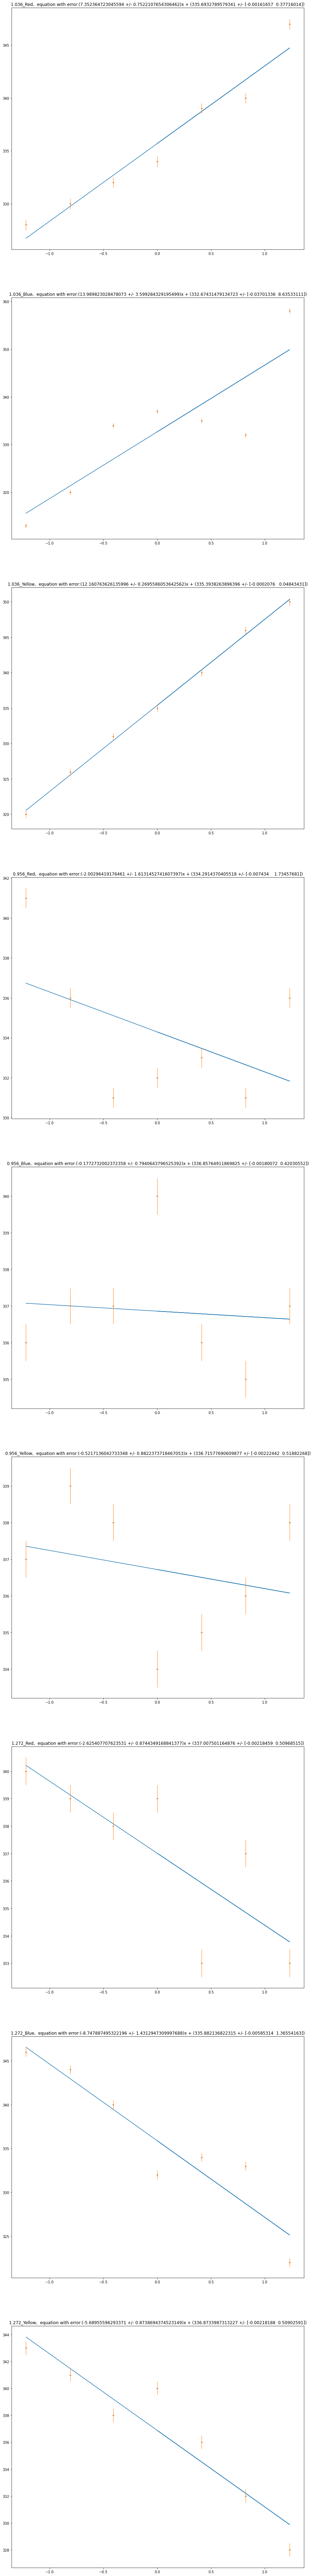

In [44]:
# n = (int)(np.sqrt(len(anglesVFieldDict)))

n = len(anglesVFieldDict)
berror = 0.01
aerror = 0.5
FIGSIZE = 15
fig, ax = plt.subplots(n, figsize = (FIGSIZE, FIGSIZE*n))
i = 0


def line(x, A, B):
    return A*x + B



for key, values in anglesVFieldDict.items():
    angle_vals = values[0]
    B_vals = values[1]
    # print(angle_vals)
    # print(B_vals)
# plt.plot(xdata, func(xdata, *popt), 'r-',
# ...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


    Berror = np.ones(len(B_vals))*berror
    angleError = np.ones(len(angle_vals))*aerror

    popt, pcov = curve_fit(line,   B_vals, angle_vals)
    perr = np.sqrt(np.diag(pcov))

    ax[i].plot(B_vals, line(B_vals, popt[0], popt[1]))
    ax[i].scatter(B_vals, angle_vals, s=5)
    ax[i].errorbar(B_vals, angle_vals, xerr = Berror, yerr = angleError, linewidth = 0, elinewidth = 1)
    
    ax[i].set_title(f"{key},  equation with error:({popt[0]} +/- {perr[0]})x + ({popt[1]} +/- {pcov[1]})")

    i+=1
    

### Zero Field Malus

In [10]:
from faraday_common import zeroFieldMalus

In [11]:
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Value 6,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,0.00250,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,0.00275,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,0.00447,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,0.00696,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,0.01620,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,0.00360,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,0.00499,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,0.00615,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,0.00202,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234


In [12]:
ZFM = zeroFieldMalus(full_df, mDict, b, m)
ZFMDict = ZFM.BvsIntensityZeroField
print(ZFMDict)

{'1.036_Red': {'current': array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22]), 'intensities': array([0.00101 , 0.0012  , 0.00343 , 0.00299 , 0.000695, 0.001   ,
       0.00269 ]), 'zero Field angles': array([335.27492589, 335.27492589, 335.27492589, 335.27492589,
       335.27492589, 335.27492589, 335.27492589]), 'rotation angles': array([338.54588126, 339.67235728, 346.31472572, 345.34836552,
       360.        , 338.47569518, 344.63504212]), 'magnetic field values': array([-1.520000e-02,  7.823740e+01,  1.564900e+02,  2.347426e+02,
       -7.826780e+01, -1.546118e+02, -2.328644e+02])}, '1.036_Blue': {'current': array([ 0.  ,  0.41,  0.82,  1.23, -0.41, -0.81, -1.22]), 'intensities': array([0.00105, 0.00289, 0.00748, 0.013  , 0.00219, 0.00965, 0.0163 ]), 'zero Field angles': array([336.14800699, 336.14800699, 336.14800699, 336.14800699,
       336.14800699, 336.14800699, 336.14800699]), 'rotation angles': array([360.        , 360.        , 347.93625837, 354.14907842,
       360. 

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

C:\Users\kalee\AppData\Local\Temp/ipykernel_10764/1756371104.py:11: RuntimeWarning: invalid value encountered in sqrt
  return np.add(np.rad2deg(np.arccos(np.sqrt(np.subtract(x,m1)/m2))),m3)
C:\Users\kalee\AppData\Local\Temp/ipykernel_10764/1756371104.py:11: RuntimeWarning: invalid value encountered in arccos
  return np.add(np.rad2deg(np.arccos(np.sqrt(np.subtract(x,m1)/m2))),m3)


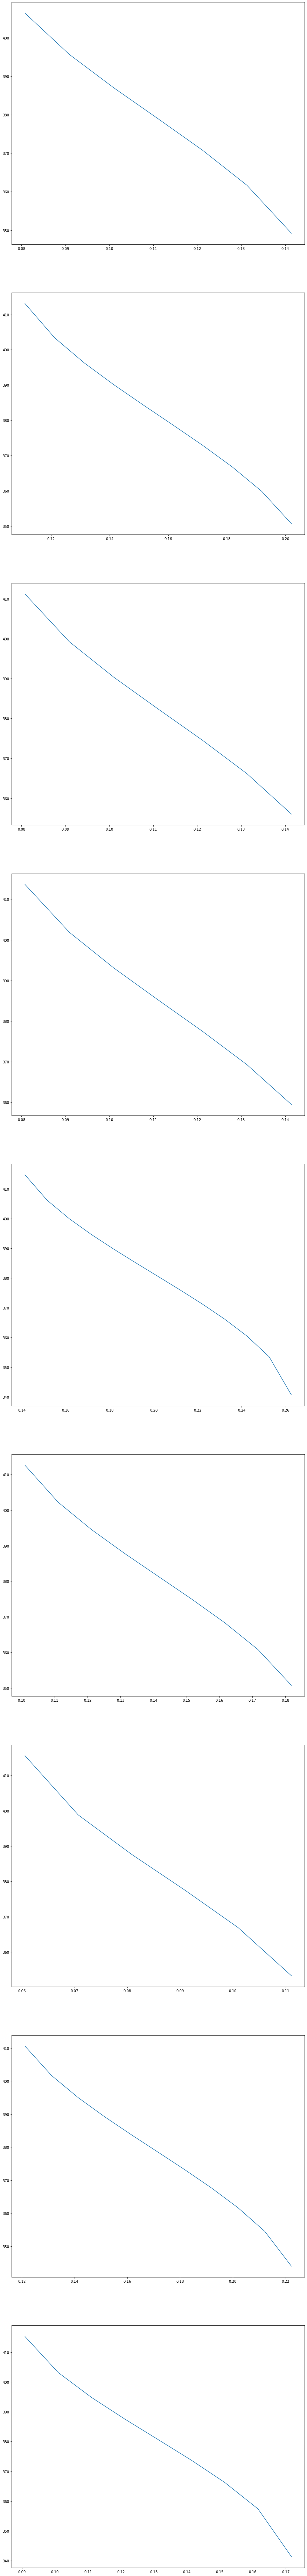

In [33]:
n = len(ZFMDict)
berror = 0.01
aerror = 0.000005
FIGSIZE = 15
fig, ax = plt.subplots(n, figsize = (FIGSIZE, FIGSIZE*n))
i = 0


def line(x, m1, m2, m3):

    return np.add(np.rad2deg(np.arccos(np.sqrt(np.subtract(x,m1)/m2))),m3)



for key, values in ZFMDict.items():
    angle_vals = values["intensities"]
    B_vals = values["magnetic field values"]
    minAngle = values["zero Field angles"][0]
    # print(angle_vals)
    # print(B_vals)
# plt.plot(xdata, func(xdata, *popt), 'r-',
# ...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

    fit_angles = np.linspace(0, 
                                 1, 
                                 100)

    print(fit_angles)
    fitted_intensities = line(fit_angles, 
                                              mDict[key]["m1"], 
                                              mDict[key]["m2"], 
                                              mDict[key]["m3"])

    print(fitted_intensities)
    ax[i].plot(fit_angles, fitted_intensities)
    # Berror = np.ones(len(B_vals))*berror
    # angleError = np.ones(len(angle_vals))*aerror

    #popt, pcov = curve_fit(line,   B_vals, angle_vals)
    # # perr = np.sqrt(np.diag(pcov))

    # # # ax[i].plot(B_vals, line(B_vals, popt[0], popt[1]))
    # ax[i].scatter(B_vals, angle_vals, s=20)
    # ax[i].errorbar(B_vals, angle_vals, xerr = Berror, yerr = angleError, linewidth = 0, elinewidth = 1)
    
    #ax[i].set_title(f"{key}, mininmum angle = {minAngle}  equation with error:({popt[0]} +/- {perr[0]})x + ({popt[1]} +/- {pcov[1]})")

    i+=1
    

In [16]:
pd.DataFrame.from_dict(ZFMDict)

,1.036_Red,1.036_Blue,1.036_Yellow,0.956_Red,0.956_Blue,0.956_Yellow,1.272_Red,1.272_Blue,1.272_Yellow
current,"[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]","[0.0, 0.41, 0.82, 1.23, -0.41, -0.81, -1.22]"
intensities,"[0.00101, 0.0012, 0.00343, 0.00299, 0.000695, ...","[0.00105, 0.00289, 0.00748, 0.013, 0.00219, 0....","[0.00101, 0.00178, 0.00421, 0.00658, 0.00189, ...","[0.00269, 0.00207, 0.00328, 0.0021, 0.00157, 0...","[0.00729, 0.00338, 0.00502, 0.00492, 0.00494, ...","[0.00431, 0.0038, 0.00315, 0.00378, 0.00452, 0...","[0.00211, 0.00133, 0.00182, 0.00131, 0.00116, ...","[0.00517, 0.00323, 0.0037, 0.00444, 0.00343, 0...","[0.00228, 0.0021, 0.00273, 0.00349, 0.00258, 0..."
zero Field angles,"[335.2749258914456, 335.2749258914456, 335.274...","[336.1480069853951, 336.1480069853951, 336.148...","[335.6961290684387, 335.6961290684387, 335.696...","[338.2878403828215, 338.2878403828215, 338.287...","[336.576889640291, 336.576889640291, 336.57688...","[336.131701637814, 336.131701637814, 336.13170...","[335.9579153280217, 335.9579153280217, 335.957...","[334.2244603817874, 334.2244603817874, 334.224...","[336.54722588931, 336.54722588931, 336.5472258..."
rotation angles,"[338.5458812571286, 339.6723572751445, 346.314...","[360.0, 360.0, 347.93625836887895, 354.1490784...","[360.0, 360.0, 345.89703552832447, 350.2655353...","[347.5032670900921, 345.8693193944829, 348.832...","[360, 360, 360, 360, 360, 360, 360]","[337.81631246842215, 360.0, 360.0, 360.0, 339....","[342.6482558412738, 360.0, 341.2549899562955, ...","[337.4391248857599, 360.0, 360.0, 360.0, 360.0...","[360.0, 360.0, 360.0, 340.93435196164063, 360...."
magnetic field values,"[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,...","[-0.0152, 78.23740000000001, 156.49, 234.7426,..."


In [20]:
mDict

{'1.036_Red': {'m1': 0.07320082950131986,
  'm2': 0.07242662219366228,
  'm3': 335.274925890484},
 '0.956_Red': {'m1': 0.07600340873265846,
  'm2': 0.07524317421585733,
  'm3': 338.28784039026385},
 '1.272_Red': {'m1': 0.058755378942364996,
  'm2': 0.05742480689139942,
  'm3': 335.95791532842117},
 '1.272_Blue': {'m1': 0.11509943462188175,
  'm2': 0.11027621309592965,
  'm3': 334.2244603785799},
 '0.956_Blue': {'m1': 0.13607536773223358,
  'm2': 0.12719212466437843,
  'm3': 336.57688964189674},
 '1.036_Blue': {'m1': 0.10586229718833813,
  'm2': 0.10266727840879811,
  'm3': 336.1480069830858},
 '1.036_Yellow': {'m1': 0.07614245258643797,
  'm2': 0.0742616330734973,
  'm3': 335.6961290674026},
 '0.956_Yellow': {'m1': 0.09596294707418054,
  'm2': 0.09173222470975656,
  'm3': 336.1317016374635},
 '1.272_Yellow': {'m1': 0.0876601595037936,
  'm2': 0.08466557881776582,
  'm3': 336.54722589233563}}